# Portfolio Optimizer
#### Trading CFDs i would like to create a portfolio that has a maximum drawdown limited to the margin call limit from the CFD broker. Trade indices and commodities and use fx to hedge currency movements. 

In [206]:
# pip install MetaTrader5


In [207]:
#import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
pd.set_option('display.max_columns', 500) # number of columns to be displayed
pd.set_option('display.width', 1500)      # max table width to display
pd.set_option('display.max_rows', 5000)
import hvplot.pandas
import pypfopt
import matplotlib.pyplot as plt
from pypfopt.expected_returns import mean_historical_return
from pypfopt import plotting, base_optimizer, risk_models, expected_returns, EfficientSemivariance, objective_functions
from pypfopt.risk_models import risk_matrix
from pypfopt.efficient_frontier import EfficientFrontier, EfficientCDaR
import seaborn as sns
import scipy.optimize as sco
import requests
from pathlib import Path
import math

## Connect to Metatrader and obtain account details

In [208]:
# Pepperstone account
# path = "C:\\Program Files\\Pepperstone MetaTrader 5\\terminal64.exe"
# login = 61196458
# password = "r4lid^Yfmo"
# server = "Pepperstone-Demo"
# timeout = 10000
# portable = False

file_path = Path("project_data_aud.csv")
df_aud_fx = pd.read_csv(file_path, index_col="time", parse_dates=True, infer_datetime_format=True)
df_aud_fx.tail()


AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx   XAUUSD_AUD  XAGUSD_AUD   ESTX50_AUD     FRA40_AUD     GER40_AUD     UK100_AUD      US30_AUD  JPN225_AUD    NAS100_AUD   SPX500_AUD   US2000_AUD     WTI_AUD
time                                                                                                                                                                                                        
2023-10-26  0.63212  1.67069  1.91816   95.049  3140.020882   36.034297  6736.756701  11481.031801  24525.428476  12261.778652  51892.884262  321.175183  22348.984370  6553.897994  2618.711637  131.652218
2023-10-27  0.63331  1.66802  1.91368   94.776  3167.974610   36.467133  6663.206134  11278.250509  24391.689983  12119.766599  51104.924918  322.974276  22402.046391  6505.850216  2579.873995  133.978620
2023-10-30  0.63740  1.66474  1.90863   95.012  3131.832444   36.562598  6725.549600  11398.807728  24579.053730  12214.863276  51659.444619  321.685682  22485.205522  6541.983056  2578.035770  129.055538
2023-10-31  0.63369  1.66847  1.91731   96.046  3130.742161   36.034970  6789.054484  11514.111470  24777.613735  12233.138617  52072.527577  326.491473  22685.287759  6611.197904  2613.328284  128.059461
2023-11-01  0.63930  1.65302  1.90023   96.510  3101.345221   35.868919  6793.912200  11513.780206  24785.348820  12184.245118  52051.384327  330.531033  22966.604098  6640.231503  2607.555138  126.231816

In [209]:
df_aud_fx[["AUDUSDx","EURAUDx","GBPAUDx","AUDJPYx","XAUUSD_AUD","XAGUSD_AUD","ESTX50_AUD","FRA40_AUD", "GER40_AUD","UK100_AUD","US30_AUD","JPN225_AUD","NAS100_AUD","SPX500_AUD","US2000_AUD","WTI_AUD"]] = df_aud_fx[["AUDUSDx","EURAUDx","GBPAUDx","AUDJPYx","XAUUSD_AUD","XAGUSD_AUD","ESTX50_AUD","FRA40_AUD", "GER40_AUD","UK100_AUD","US30_AUD","JPN225_AUD","NAS100_AUD","SPX500_AUD","US2000_AUD","WTI_AUD"]].apply(pd.to_numeric)

In [210]:
#df_aud_fx.set_index("time")
df_aud_fx.dtypes

AUDUSDx       float64
EURAUDx       float64
GBPAUDx       float64
AUDJPYx       float64
XAUUSD_AUD    float64
XAGUSD_AUD    float64
ESTX50_AUD    float64
FRA40_AUD     float64
GER40_AUD     float64
UK100_AUD     float64
US30_AUD      float64
JPN225_AUD    float64
NAS100_AUD    float64
SPX500_AUD    float64
US2000_AUD    float64
WTI_AUD       float64
dtype: object

In [211]:
#Calculate daily change stocks
combined_returns = df_aud_fx.pct_change()
combined_returns = combined_returns.dropna()
combined_returns = combined_returns.drop(columns=["AUDUSDx","EURAUDx","GBPAUDx","AUDJPYx"])
combined_returns.head()

XAUUSD_AUD  XAGUSD_AUD  ESTX50_AUD  FRA40_AUD  GER40_AUD  UK100_AUD  US30_AUD  JPN225_AUD  NAS100_AUD  SPX500_AUD  US2000_AUD   WTI_AUD
time                                                                                                                                               
2012-08-31    0.018883    0.037073    0.013181   0.008725   0.011075   0.001739  0.005554   -0.003084    0.004299    0.004191   -0.002093  0.018933
2012-09-03    0.008487    0.021539    0.019378   0.024344   0.016450   0.016393  0.007605   -0.001406    0.009346    0.008029    0.019381  0.010031
2012-09-04    0.003658    0.009012   -0.007509  -0.012252  -0.007786  -0.012138 -0.002838   -0.002528   -0.000697   -0.001017    0.008451 -0.013380
2012-09-05    0.001306    0.000538    0.002174   0.003811   0.006889   0.001451  0.004869   -0.005701    0.002660    0.003665    0.003510  0.007124
2012-09-06   -0.004359    0.003320    0.030027   0.024383   0.022125   0.014621  0.008636    0.004969    0.011738    0.010657    0.009397 -0.018511

In [212]:
# Plot returns to visualise data

cum_returns_index = (1 + combined_returns).cumprod(axis=0)
cum_returns_index

# Plot cumulative returns
cum_returns_index.hvplot(
    width=1500,
    height=900,
    rot=45
)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [213]:
# Calculate the annualized `std`
portfolio_std = combined_returns.std() * np.sqrt(252)
#portfolio_std.plot(kind="bar", title="Sharpe Ratios")
portfolio_std.hvplot.bar( title="annualised standard deviation", rot=45)

:Bars   [index]   (0)

In [214]:
#Plot covariance
co_var = risk_models.risk_matrix(df_aud_fx, method='sample_cov')
co_var

AUDUSDx   EURAUDx   GBPAUDx   AUDJPYx  XAUUSD_AUD  XAGUSD_AUD  ESTX50_AUD  FRA40_AUD  GER40_AUD  UK100_AUD  US30_AUD  JPN225_AUD  NAS100_AUD  SPX500_AUD  US2000_AUD   WTI_AUD
AUDUSDx     0.010439 -0.006267 -0.005277  0.007950   -0.004825    0.001170    0.000420   0.000145   0.000206  -0.001172 -0.003580   -0.002540   -0.002489   -0.003117   -0.001644 -0.000757
EURAUDx    -0.006267  0.008545  0.005626 -0.006517    0.004812    0.001538    0.001690   0.001933   0.001774   0.003202  0.000654    0.000384   -0.000056    0.000453   -0.000955 -0.001718
GBPAUDx    -0.005277  0.005626  0.008953 -0.004923    0.003426    0.001291    0.002514   0.002551   0.002599   0.000937  0.002099    0.001794    0.001457    0.001963    0.001303  0.001404
AUDJPYx     0.007950 -0.006517 -0.004923  0.014064   -0.007872   -0.002310    0.006370   0.005976   0.005637   0.003405  0.002725    0.002553    0.003571    0.003035    0.005289  0.005694
XAUUSD_AUD -0.004825  0.004812  0.003426 -0.007872    0.021007    0.024523   -0.003716  -0.003562  -0.003336  -0.001089 -0.001719   -0.001133   -0.001972   -0.001798   -0.003176  0.001536
XAGUSD_AUD  0.001170  0.001538  0.001291 -0.002310    0.024523    0.058695    0.001691   0.001582   0.001946   0.002765 -0.000098    0.001010    0.001114    0.000301    0.001264  0.010648
ESTX50_AUD  0.000420  0.001690  0.002514  0.006370   -0.003716    0.001691    0.035375   0.033814   0.033355   0.024514  0.021303    0.018385    0.023686    0.021871    0.025054  0.014008
FRA40_AUD   0.000145  0.001933  0.002551  0.005976   -0.003562    0.001582    0.033814   0.034217   0.031663   0.024461  0.020753    0.017409    0.022035    0.020979    0.024293  0.014405
GER40_AUD   0.000206  0.001774  0.002599  0.005637   -0.003336    0.001946    0.033355   0.031663   0.034768   0.023519  0.020769    0.017623    0.023115    0.021099    0.024729  0.011699
UK100_AUD  -0.001172  0.003202  0.000937  0.003405   -0.001089    0.002765    0.024514   0.024461   0.023519   0.024681  0.017156    0.013476    0.017003    0.016847    0.019363  0.015220
US30_AUD   -0.003580  0.000654  0.002099  0.002725   -0.001719   -0.000098    0.021303   0.020753   0.020769   0.017156  0.024908    0.016199    0.024579    0.023782    0.025544  0.014997
JPN225_AUD -0.002540  0.000384  0.001794  0.002553   -0.001133    0.001010    0.018385   0.017409   0.017623   0.013476  0.016199    0.025575    0.019176    0.016990    0.018694  0.009225
NAS100_AUD -0.002489 -0.000056  0.001457  0.003571   -0.001972    0.001114    0.023686   0.022035   0.023115   0.017003  0.024579    0.019176    0.038446    0.028373    0.029336  0.011126
SPX500_AUD -0.003117  0.000453  0.001963  0.003035   -0.001798    0.000301    0.021871   0.020979   0.021099   0.016847  0.023782    0.016990    0.028373    0.025111    0.026766  0.014100
US2000_AUD -0.001644 -0.000955  0.001303  0.005289   -0.003176    0.001264    0.025054   0.024293   0.024729   0.019363  0.025544    0.018694    0.029336    0.026766    0.040263  0.017178
WTI_AUD    -0.000757 -0.001718  0.001404  0.005694    0.001536    0.010648    0.014008   0.014405   0.011699   0.015220  0.014997    0.009225    0.011126    0.014100    0.017178  0.160586

In [215]:
mu = expected_returns.mean_historical_return(df_aud_fx, returns_data=False, compounding=True, frequency=252, log_returns=False)
S = risk_models.sample_cov(df_aud_fx, returns_data=False, frequency=252, log_returns=False)

OrderedDict([('AUDUSDx', 0.0), ('EURAUDx', 0.0), ('GBPAUDx', 0.0), ('AUDJPYx', 0.0), ('XAUUSD_AUD', 0.32057), ('XAGUSD_AUD', 0.0), ('ESTX50_AUD', 0.0), ('FRA40_AUD', 0.0), ('GER40_AUD', 0.0), ('UK100_AUD', 0.0), ('US30_AUD', 0.0), ('JPN225_AUD', 0.0), ('NAS100_AUD', 0.67943), ('SPX500_AUD', 0.0), ('US2000_AUD', 0.0), ('WTI_AUD', 0.0)])
Expected annual return: 16.6%
Annual volatility: 13.8%
Sharpe Ratio: 1.06


<Axes: xlabel='Weight'>

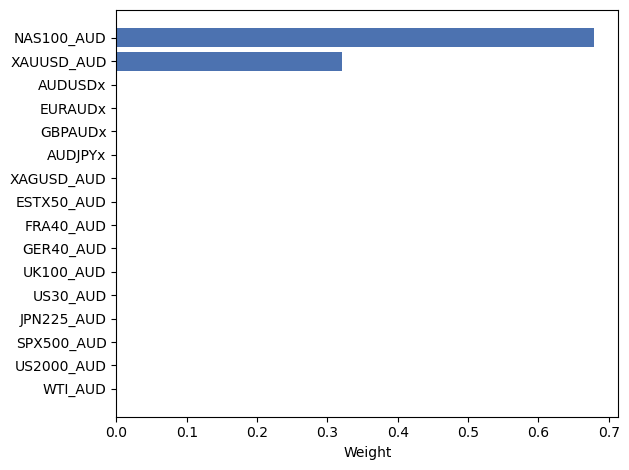

In [216]:
# Optimize the max sharpe ratio without shorts
ef = EfficientFrontier(mu,S,verbose=False, weight_bounds=(0,None))
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights, ax=None)

In [217]:

cleaned_weights_1 = pd.DataFrame(cleaned_weights, index = [0])
#cleaned_weights_1["time"] = "2012-08-30"
#cleaned_weights_1.set_index("time")
cleaned_weights_1 = cleaned_weights_1.drop(columns=["AUDUSDx","EURAUDx","GBPAUDx","AUDJPYx"])
#cleaned_weights_1["time"] = "2012-08-30"
cleaned_weights_1

XAUUSD_AUD  XAGUSD_AUD  ESTX50_AUD  FRA40_AUD  GER40_AUD  UK100_AUD  US30_AUD  JPN225_AUD  NAS100_AUD  SPX500_AUD  US2000_AUD  WTI_AUD
0     0.32057         0.0         0.0        0.0        0.0        0.0       0.0         0.0     0.67943         0.0         0.0      0.0

In [218]:
#cleaned_weights_1.set_index("time")
#cleaned_weights_1

In [219]:
new_weights = [cleaned_weights_1,combined_returns]
result = pd.concat(new_weights)
#result.drop(columns="time")
result.head()

XAUUSD_AUD  XAGUSD_AUD  ESTX50_AUD  FRA40_AUD  GER40_AUD  UK100_AUD  US30_AUD  JPN225_AUD  NAS100_AUD  SPX500_AUD  US2000_AUD   WTI_AUD
0                      0.320570    0.000000    0.000000   0.000000   0.000000   0.000000  0.000000    0.000000    0.679430    0.000000    0.000000  0.000000
2012-08-31 00:00:00    0.018883    0.037073    0.013181   0.008725   0.011075   0.001739  0.005554   -0.003084    0.004299    0.004191   -0.002093  0.018933
2012-09-03 00:00:00    0.008487    0.021539    0.019378   0.024344   0.016450   0.016393  0.007605   -0.001406    0.009346    0.008029    0.019381  0.010031
2012-09-04 00:00:00    0.003658    0.009012   -0.007509  -0.012252  -0.007786  -0.012138 -0.002838   -0.002528   -0.000697   -0.001017    0.008451 -0.013380
2012-09-05 00:00:00    0.001306    0.000538    0.002174   0.003811   0.006889   0.001451  0.004869   -0.005701    0.002660    0.003665    0.003510  0.007124

In [220]:
cum_returns_portfolio = (1 + result).cumprod(axis=0)-1
cum_returns_portfolio.head()

XAUUSD_AUD  XAGUSD_AUD  ESTX50_AUD  FRA40_AUD  GER40_AUD  UK100_AUD  US30_AUD  JPN225_AUD  NAS100_AUD  SPX500_AUD  US2000_AUD   WTI_AUD
0                      0.320570    0.000000    0.000000   0.000000   0.000000   0.000000  0.000000    0.000000    0.679430    0.000000    0.000000  0.000000
2012-08-31 00:00:00    0.345507    0.037073    0.013181   0.008725   0.011075   0.001739  0.005554   -0.003084    0.686650    0.004191   -0.002093  0.018933
2012-09-03 00:00:00    0.356926    0.059410    0.032814   0.033281   0.027707   0.018160  0.013201   -0.004486    0.702413    0.012253    0.017247  0.029154
2012-09-04 00:00:00    0.361890    0.068958    0.025058   0.020621   0.019706   0.005802  0.010325   -0.007002    0.701226    0.011224    0.025844  0.015384
2012-09-05 00:00:00    0.363669    0.069533    0.027286   0.024511   0.026730   0.007261  0.015244   -0.012664    0.705750    0.014930    0.029444  0.022617

In [221]:
cum_returns_portfolio["Total value"] = cum_returns_portfolio["XAUUSD_AUD"]+cum_returns_portfolio["NAS100_AUD"]
cum_returns_portfolio.tail()

XAUUSD_AUD  XAGUSD_AUD  ESTX50_AUD  FRA40_AUD  GER40_AUD  UK100_AUD  US30_AUD  JPN225_AUD  NAS100_AUD  SPX500_AUD  US2000_AUD   WTI_AUD  Total value
2023-10-26 00:00:00    1.578515    0.218807    1.298697   1.796742   1.926548   0.766239  3.112949    1.916386   13.037577    3.825524    2.339498  0.433136    14.616091
2023-10-27 00:00:00    1.601470    0.233447    1.273600   1.747345   1.910590   0.745783  3.050496    1.932722   13.070905    3.790147    2.289971  0.458461    14.672375
2023-10-30 00:00:00    1.571791    0.236676    1.294873   1.776712   1.932947   0.759481  3.094447    1.921022   13.123138    3.816751    2.287626  0.404870    14.694929
2023-10-31 00:00:00    1.570895    0.218830    1.316542   1.804800   1.956641   0.762113  3.127187    1.964660   13.248812    3.867713    2.332633  0.394026    14.819707
2023-11-01 00:00:00    1.546755    0.213213    1.318199   1.804719   1.957564   0.755071  3.125511    2.001340   13.425509    3.889090    2.325271  0.374131    14.972264

In [222]:
portfolio_returns = cum_returns_portfolio["Total value"].pct_change()
portfolio_returns = portfolio_returns.iloc[1:]
portfolio_returns.head()

2012-08-31 00:00:00    0.032156
2012-09-03 00:00:00    0.026336
2012-09-04 00:00:00    0.003566
2012-09-05 00:00:00    0.005929
2012-09-06 00:00:00    0.013164
Name: Total value, dtype: float64

In [223]:
portfolio_returns.size

2784

In [224]:
sorted_portfolio_returns = portfolio_returns.sort_values()
sorted_portfolio_returns.head()

2013-04-15   -0.101855
2020-03-16   -0.098565
2013-06-20   -0.070296
2020-03-12   -0.060742
2013-04-12   -0.059650
Name: Total value, dtype: float64

In [225]:
quantile_value = sorted_portfolio_returns.quantile(0.01)
quantile_number = math.ceil(portfolio_returns.size*0.01)
quantile_number
sorted_portfolio_returns.iloc[0:quantile_number].mean()

-0.05050571189313018

In [226]:
print(cum_returns_portfolio["Total value"].tail(1))
print(cum_returns_portfolio["Total value"].head(2))
#yearly_return = total_pf_return**(1/10)-1
total_pf_return = 14.972264**(1/10)-1
print(total_pf_return)

2023-11-01 00:00:00    14.972264
Name: Total value, dtype: float64
0                      1.000000
2012-08-31 00:00:00    1.032156
Name: Total value, dtype: float64
0.31077680486206805


In [227]:
### Cdar with AUD returns and FX

In [228]:
mu_aud_fx = expected_returns.mean_historical_return(df_aud_fx, returns_data=False, compounding=True, frequency=252, log_returns=False)
historical_returns_aud_fx = expected_returns.returns_from_prices(df_aud_fx).dropna()

Expected annual return: 12.9%
Conditional Drawdown at Risk: 10.00%


AUDUSDx  EURAUDx  GBPAUDx  AUDJPYx  XAUUSD_AUD  XAGUSD_AUD  ESTX50_AUD  FRA40_AUD  GER40_AUD  UK100_AUD  US30_AUD  JPN225_AUD  NAS100_AUD  SPX500_AUD  US2000_AUD  WTI_AUD
0      0.0      0.0      0.0  0.04742     0.38572         0.0         0.0        0.0        0.0        0.0   0.12026         0.0     0.40341         0.0         0.0  0.04318

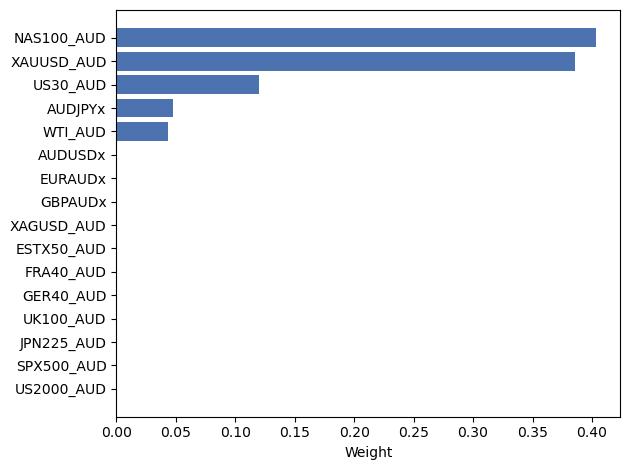

In [229]:
ef_cdar_aud_fx = EfficientCDaR(mu_aud_fx, historical_returns_aud_fx, weight_bounds=(0,1), beta=0.99, verbose=False)
# ef_cdar.add_objective(objective_functions.L2_reg, gamma=.3)
weights_aud_fx = ef_cdar_aud_fx.efficient_risk(0.1, market_neutral=False)
cleaned_weights_aud_fx = ef_cdar_aud_fx.clean_weights()
ef_cdar_aud_fx.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights_aud_fx, ax=None)

# Create dataframe for weight to be easily displayed
cleaned_weights_2 = pd.DataFrame(cleaned_weights_aud_fx, index=[0])
display(cleaned_weights_2)

In [4]:
# display relevant information
print("Profit:", account_info_df["profit"].loc[0])
print("Equity:", account_info_df["equity"].loc[0])
print("Margin:", account_info_df["margin"].loc[0])
print("Margin Free:", account_info_df["margin_free"].loc[0])

Profit: 0.0
Equity: 100000.0
Margin: 0.0
Margin Free: 100000.0


## Retrieve ticker data from Metatrader and concatenate into dataframe for PyportfolioOpt analyse

In [5]:
# Get bars function to recieve daily ticker data
def get_bars_data(symbol):

    # set time zone to UTC
    timezone = pytz.timezone("Etc/UTC")
    # create 'datetime' object in UTC time zone to avoid the implementation of a local time zone offset
    utc_from = datetime(2010, 11, 1, tzinfo=timezone)
    utc_to = datetime(2023, 11, 1, tzinfo=timezone)
    # get 10 EURUSD H4 bars starting from 01.10.2020 in UTC time zone
    rates = mt5.copy_rates_range(symbol, mt5.TIMEFRAME_D1, utc_from, utc_to)
    # create DataFrame out of the obtained data
    rates_frame = pd.DataFrame(rates)
    # convert time in seconds into the datetime format
    rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
    #Set index to time
    rates_frame = rates_frame.set_index('time')
    # Remove unwanted columns
    rates_frame = rates_frame['close']
    # Change series into df
    rates_frame = pd.DataFrame(rates_frame)
    #Rename column to symbol
    rates_frame = rates_frame.rename(columns={'close':symbol})
    return rates_frame
    
    

In [6]:
EURUSDx = get_bars_data('EURUSDx')
AUDUSDx = get_bars_data('AUDUSDx')
GBPUSDx = get_bars_data('GBPUSDx')
USDJPYx = get_bars_data('USDJPYx')
USDCHFx = get_bars_data('USDCHFx')
XAUUSDx = get_bars_data('XAUUSDx')
XAUEURx = get_bars_data('XAUEURx')
XAGUSDx = get_bars_data('XAGUSDx')
GBPAUDx = get_bars_data('GBPAUDx')
EURAUDx = get_bars_data('EURAUDx')
BRENT = get_bars_data('BRENT')
NGAS = get_bars_data('NGAS')
COPPER = get_bars_data('COPPER')
WTI = get_bars_data('WTI')
BRENT = get_bars_data('BRENT')
WHEAT = get_bars_data('WHEAT')
CORN = get_bars_data('CORN')
SOYBEANS = get_bars_data('SOYBEANS')
ESTX50 = get_bars_data('ESTX50')
FRA40 = get_bars_data('FRA40')
GER40 = get_bars_data('GER40')
AUS200 = get_bars_data('AUS200')
UK100 = get_bars_data('UK100')
US30 = get_bars_data('US30')
JPN225 = get_bars_data('JPN225')
NAS100 = get_bars_data('NAS100')
SPX500 = get_bars_data('SPX500')
US2000 = get_bars_data('US2000')
ETHUSD = get_bars_data('ETHUSD')
BTCUSD = get_bars_data('BTCUSD')

In [7]:
# Concatenate dataframes
df = pd.concat([XAUUSDx, XAGUSDx,   
                ESTX50, FRA40, GER40, AUS200, UK100, US30, JPN225, NAS100, SPX500, US2000,
                WTI  # Added currencies may need to remove, dont think currency for growth is good because past performance is not indicitave of future performance. 
               ], join='outer', axis=1)
df = df.dropna()
display(df.head(3))
display(df.tail(3))

# deleted these as they had the most nans SOYBEANS, XAUEURx,COPPER, NGAS, WHEAT, CORN, ETHUSD, BTCUSD, AUDUSDx, GBPAUDx, EURAUDx
# removed fx to check returns without them GBPUSDx, AUDUSDx, USDCHFx,EURUSDx,USDJPYx

XAUUSDx  XAGUSDx  ESTX50   FRA40   GER40  AUS200   UK100     US30  JPN225  NAS100  SPX500  US2000    WTI
time                                                                                                                
2012-08-30  1655.18    30.43  2413.0  3380.0  6900.0  4301.0  5716.0  12986.0  8910.0  2752.0  1397.9   807.1  94.55
2012-08-31  1690.81    31.64  2438.0  3400.0  6957.0  4339.0  5710.0  13092.0  8880.0  2771.0  1407.4   807.5  96.59
2012-09-03  1692.42    32.08  2464.0  3453.0  7011.0  4335.0  5754.0  13093.0  8790.0  2776.0  1408.1   817.0  96.83

XAUUSDx  XAGUSDx   ESTX50   FRA40     GER40   AUS200    UK100      US30    JPN225    NAS100   SPX500   US2000    WTI
time                                                                                                                            
2023-10-30  1996.23   23.305  4040.00  6847.2  14764.50  6803.05  7337.40  32927.73  30564.00  14332.07  4169.86  1643.24  82.26
2023-10-31  1983.92   22.835  4069.03  6901.0  14850.50  6809.50  7331.95  32997.84  31358.20  14375.44  4189.45  1656.04  81.15
2023-11-01  1982.69   22.931  4110.00  6965.3  14993.98  6886.62  7370.90  33276.45  31899.55  14682.55  4245.10  1667.01  80.70

In [8]:
df.isna().sum()

XAUUSDx    0
XAGUSDx    0
ESTX50     0
FRA40      0
GER40      0
AUS200     0
UK100      0
US30       0
JPN225     0
NAS100     0
SPX500     0
US2000     0
WTI        0
dtype: int64

In [9]:
# Function to calculate average gain for each column
def calculate_average_gain(column):
    first_row = column.iloc[0]  # First row value
    last_row = column.iloc[-1]  # Last row value
    average_gain = ((last_row - first_row) / first_row) * 100
    return average_gain

# Loop through each column in the DataFrame
for col in df.columns:
    avg_gain = calculate_average_gain(df[col])
    print(f"Column '{col}': Average Gain = {avg_gain}")

    

Column 'XAUUSDx': Average Gain = 19.786971809712536
Column 'XAGUSDx': Average Gain = -24.643443969766672
Column 'ESTX50': Average Gain = 70.32739328636552
Column 'FRA40': Average Gain = 106.07396449704143
Column 'GER40': Average Gain = 117.30405797101449
Column 'AUS200': Average Gain = 60.11671704254824
Column 'UK100': Average Gain = 28.952064380685787
Column 'US30': Average Gain = 156.2486523948868
Column 'JPN225': Average Gain = 258.0196408529742
Column 'NAS100': Average Gain = 433.52289244186045
Column 'SPX500': Average Gain = 203.6769439874097
Column 'US2000': Average Gain = 106.54317928385578
Column 'WTI': Average Gain = -14.648334214701212


In [10]:
#Calculate daily change stocks
combined_returns = df.pct_change()
combined_returns = combined_returns.dropna()

display(combined_returns)

XAUUSDx   XAGUSDx    ESTX50     FRA40     GER40    AUS200     UK100      US30    JPN225    NAS100    SPX500    US2000       WTI
time                                                                                                                                        
2012-08-31  0.021526  0.039763  0.010361  0.005917  0.008261  0.008835 -0.001050  0.008163 -0.003367  0.006904  0.006796  0.000496  0.021576
2012-09-03  0.000952  0.013906  0.010664  0.015588  0.007762 -0.000922  0.007706  0.000076 -0.010135  0.001804  0.000497  0.011765  0.002485
2012-09-04  0.001826  0.007170 -0.007711 -0.012453 -0.007987 -0.011534 -0.012339 -0.004659 -0.002503 -0.002522 -0.002841  0.006610 -0.015181
2012-09-05 -0.001710 -0.002476 -0.003681 -0.002053  0.001006  0.006301 -0.004399  0.001842 -0.009124 -0.000361  0.000641  0.000486  0.004090
2012-09-06  0.004354  0.012101  0.036535  0.030855  0.028584  0.009972  0.021032  0.017463  0.019797  0.020592  0.019502  0.018230 -0.009922
2012-09-07  0.020694  0.031576  0.005941  0.003706  0.008658 -0.002067  0.002770  0.001129 -0.000790 -0.000708  0.004538 -0.000239  0.015823
2012-09-10 -0.005348 -0.009510 -0.010236 -0.008520 -0.004707 -0.006213 -0.003970 -0.005113 -0.005083 -0.013815 -0.008548 -0.000119 -0.000727
2012-09-11  0.003366  0.003900  0.015911  0.011744  0.015162  0.003010  0.002946  0.005215  0.000227 -0.001796  0.002804  0.002866  0.006443
2012-09-12 -0.000768 -0.008368  0.001958  0.002831  0.005344  0.002539 -0.000864  0.003985  0.015891  0.005038  0.005592  0.007739  0.000826
2012-09-13  0.020903  0.043701  0.006643  0.000282  0.006406  0.009440  0.016603  0.013780  0.011173  0.013605  0.014598  0.011815  0.012380
2012-09-14  0.001936 -0.000289  0.002717  0.008185  0.000542  0.005246  0.003743  0.003694  0.020884  0.008831  0.004453  0.001868  0.008764
2012-09-17 -0.005158 -0.012998 -0.001936 -0.007279  0.000000 -0.004084 -0.004915 -0.003091 -0.009200 -0.001050 -0.003206  0.002214 -0.020608
2012-09-18  0.005946  0.018145 -0.010085 -0.008742 -0.004467  0.000000 -0.000341  0.002510  0.001420  0.002103 -0.000205 -0.001163 -0.012893
2012-09-19 -0.000762 -0.006036  0.005094  0.004267  0.003399  0.003190  0.003919 -0.000884  0.001309  0.000350 -0.001164 -0.004308 -0.036782
2012-09-20 -0.000949  0.001735 -0.005068 -0.003966  0.001491 -0.000681 -0.005431  0.002211 -0.007626  0.000350  0.001370 -0.000585  0.006726
2012-09-21  0.002539 -0.006640  0.007053  0.001706  0.006900  0.000455 -0.003242 -0.001839 -0.002415 -0.000699 -0.001916  0.001872  0.003233
2012-09-24 -0.004987 -0.013659 -0.003891 -0.005111 -0.003091 -0.005452  0.000342 -0.000442 -0.005612 -0.004897  0.000343 -0.003620 -0.011278
2012-09-25 -0.002007 -0.006187 -0.009375 -0.008847 -0.009435 -0.006852 -0.005819 -0.006339 -0.004980 -0.012302 -0.010075 -0.013947 -0.013580
2012-09-26 -0.004641  0.005633 -0.014590 -0.015261 -0.009389  0.000230 -0.007574 -0.003116 -0.014236 -0.008897 -0.006231 -0.009747 -0.005727
2012-09-27  0.014159  0.019752  0.009204  0.010819  0.006593  0.005519  0.005898  0.004093  0.012298  0.012926  0.008848  0.012964  0.021267
2012-09-28 -0.002696 -0.006649 -0.025773 -0.028927 -0.012282 -0.002744 -0.009140 -0.004224 -0.014267 -0.008862 -0.005524 -0.000118 -0.002061
2012-10-01  0.001591  0.007858  0.007733  0.014298  0.004836  0.008714  0.007658  0.005284 -0.003618 -0.001073  0.001944 -0.004859  0.003152
2012-10-02 -0.000456 -0.001444  0.006462  0.001468  0.005362  0.009548  0.002591 -0.002443 -0.005107  0.002148  0.001733  0.000476 -0.007042
2012-10-03  0.001883 -0.000289 -0.001605 -0.003226  0.000821  0.000225  0.001723  0.003488  0.001369  0.007145  0.005327 -0.000952 -0.036443
2012-10-04  0.007032  0.012149  0.002412  0.004413  0.000683  0.004502  0.004643  0.003698  0.007176  0.003547  0.006400  0.005957  0.035557
2012-10-05 -0.005765 -0.015719  0.008420  0.005565  0.005599  0.006275 -0.000171  0.002211  0.004185 -0.006716 -0.001573  0.001421 -0.017059
2012-10-08 -0.002854 -0.013937 -0.005567 -0.005243 -0.008012  0.0

## Analyse data

In [11]:
# Plot returns to visualise data

cum_returns_index = (1 + combined_returns).cumprod(axis=0)
cum_returns_index

# Plot cumulative returns
cum_returns_index.hvplot(
    width=1500,
    height=900,
    rot=45
)

:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [12]:
# Calculate the annualized `std`
portfolio_std = combined_returns.std() * np.sqrt(252)
#portfolio_std.plot(kind="bar", title="Sharpe Ratios")
portfolio_std.hvplot.bar( title="annualised standard deviation", rot=45)

:Bars   [index]   (0)

In [13]:
#Plot covariance
co_var = risk_models.risk_matrix(df, method='sample_cov')
co_var

XAUUSDx   XAGUSDx    ESTX50     FRA40     GER40    AUS200     UK100      US30    JPN225    NAS100    SPX500    US2000       WTI
XAUUSDx  0.021766  0.031273 -0.001836 -0.001959 -0.001663 -0.000007 -0.000799  0.000337 -0.003566  0.001189  0.000721  0.000805  0.006385
XAGUSDx  0.031273  0.071399  0.006772  0.006380  0.006823  0.006487  0.006261  0.007911  0.004102  0.010235  0.008776  0.011177  0.021379
ESTX50  -0.001836  0.006772  0.040344  0.038524  0.038242  0.025739  0.027990  0.027193  0.030751  0.030296  0.027972  0.032513  0.022163
FRA40   -0.001959  0.006380  0.038524  0.038666  0.036291  0.025387  0.027682  0.026358  0.029372  0.028361  0.026794  0.031464  0.022282
GER40   -0.001663  0.006823  0.038242  0.036291  0.039572  0.024962  0.026917  0.026455  0.029263  0.029517  0.026994  0.031983  0.019661
AUS200  -0.000007  0.006487  0.025739  0.025387  0.024962  0.031622  0.021958  0.022168  0.022252  0.023871  0.022425  0.026302  0.023870
UK100   -0.000799  0.006261  0.027990  0.027682  0.026917  0.021958  0.026665  0.021483  0.022900  0.022045  0.021379  0.025265  0.021845
US30     0.000337  0.007911  0.027193  0.026358  0.026455  0.022168  0.021483  0.028108  0.024247  0.028860  0.027446  0.030647  0.020949
JPN225  -0.003566  0.004102  0.030751  0.029372  0.029263  0.022252  0.022900  0.024247  0.044691  0.028068  0.025351  0.029279  0.020178
NAS100   0.001189  0.010235  0.030296  0.028361  0.029517  0.023871  0.022045  0.028860  0.028068  0.043809  0.033119  0.035520  0.018202
SPX500   0.000721  0.008776  0.027972  0.026794  0.026994  0.022425  0.021379  0.027446  0.025351  0.033119  0.029239  0.032333  0.020524
US2000   0.000805  0.011177  0.032513  0.031464  0.031983  0.026302  0.025265  0.030647  0.029279  0.035520  0.032333  0.047248  0.025012
WTI      0.006385  0.021379  0.022163  0.022282  0.019661  0.023870  0.021845  0.020949  0.020178  0.018202  0.020524  0.025012  0.169031

<AxesSubplot:>

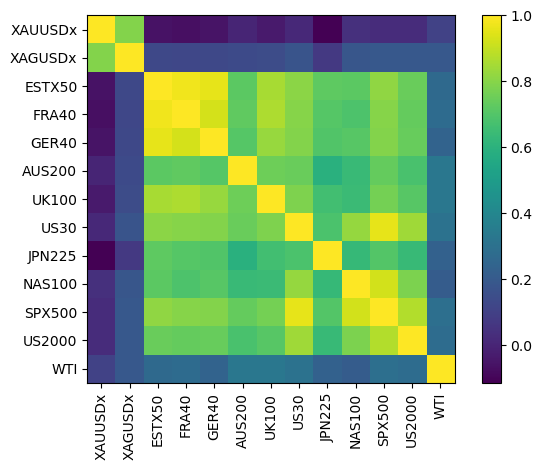

In [14]:
plotting.plot_covariance(co_var, plot_correlation=True, show_tickers=True)

## Generate Effcicent Frontier

In [15]:
mu = expected_returns.mean_historical_return(df, returns_data=False, compounding=True, frequency=252, log_returns=False)
S = risk_models.sample_cov(df, returns_data=False, frequency=252, log_returns=False)


### Max Sharpe Long only

OrderedDict([('XAUUSDx', 0.0), ('XAGUSDx', 0.0), ('ESTX50', 0.0), ('FRA40', 0.0), ('GER40', 0.0), ('AUS200', 0.0), ('UK100', 0.0), ('US30', 0.0), ('JPN225', 0.11332), ('NAS100', 0.88668), ('SPX500', 0.0), ('US2000', 0.0), ('WTI', 0.0)])
Expected annual return: 15.9%
Annual volatility: 20.2%
Sharpe Ratio: 0.69


<AxesSubplot:xlabel='Weight'>

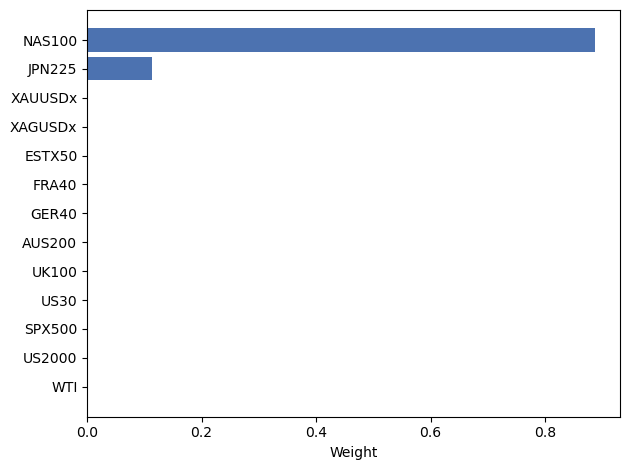

In [16]:
# Optimize the max sharpe ratio
ef = EfficientFrontier(mu,S,verbose=False, weight_bounds=(0,None))
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights, ax=None)

## Max Sharpe Ratio with shorts

OrderedDict([('XAUUSDx', 0.91918), ('XAGUSDx', -0.50363), ('ESTX50', -1.0), ('FRA40', 0.85452), ('GER40', 0.31608), ('AUS200', -0.15904), ('UK100', -0.73945), ('US30', 0.62421), ('JPN225', 0.49894), ('NAS100', 1.0), ('SPX500', -0.25337), ('US2000', -0.54312), ('WTI', -0.01432)])
Expected annual return: 25.2%
Annual volatility: 19.4%
Sharpe Ratio: 1.19


<AxesSubplot:xlabel='Weight'>

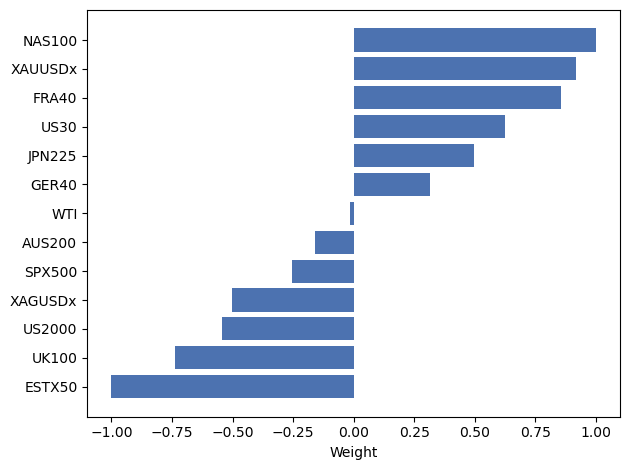

In [17]:
# Optimize the max sharpe ratio
ef = EfficientFrontier(mu,S,verbose=False, weight_bounds=(-1, 1))
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights, ax=None)

## Efficient Cdar


In [18]:
mu = expected_returns.mean_historical_return(df, returns_data=False, compounding=True, frequency=252, log_returns=False)
historical_returns = expected_returns.returns_from_prices(df).dropna()

XAUUSDx  XAGUSDx  ESTX50  FRA40    GER40   AUS200    UK100  US30   JPN225  NAS100   SPX500  US2000     WTI
0  0.57841 -0.18498    -1.0    1.0  0.09551 -0.30771 -0.21941   1.0  0.83083     1.0 -0.91265 -0.9035  0.0235

Expected annual return: 21.7%
Conditional Drawdown at Risk: 15.00%


<AxesSubplot:xlabel='Weight'>

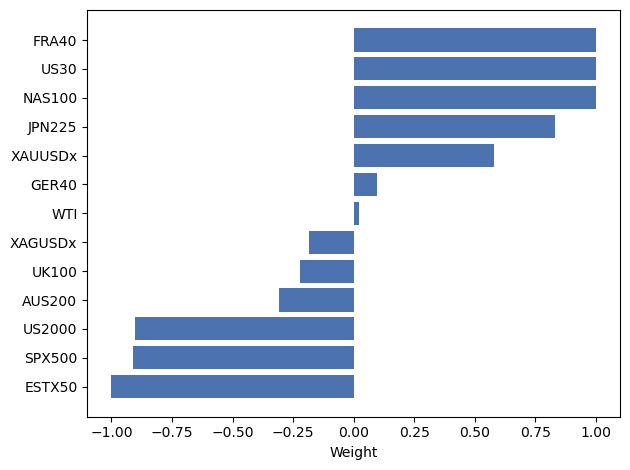

In [20]:
ef_cdar = EfficientCDaR(mu, historical_returns, weight_bounds=(-1,1), beta=0.99, verbose=False)
# ef_cdar.add_objective(objective_functions.L2_reg, gamma=.3)
weights = ef_cdar.efficient_risk(0.15, market_neutral=False)
cleaned_weights = ef_cdar.clean_weights()
cleaned_weights_1 = pd.DataFrame(cleaned_weights, index=[0])
display(cleaned_weights_1)
ef_cdar.portfolio_performance(verbose=True)
plotting.plot_weights(cleaned_weights, ax=None)


## Portfolio calc. Needs work

In [22]:
# Calculate weighting for short and long positions for portfolio

# Calculate long and short weights separately
long_weights = {ticker: weight for ticker, weight in cleaned_weights.items() if weight > 0}
# print(long_weights)
short_weights = {ticker: weight for ticker, weight in cleaned_weights.items() if weight < 0}
# print(short_weights)

# Calculate total long and short weights
total_long_weight = sum(long_weights.values())
# print(total_long_weight)
total_short_weight = abs(sum(short_weights.values()))
# print(total_short_weight)

short_long_total = total_long_weight + total_short_weight
# print(short_long_total)

# Calculate long and short allocations based on the total portfolio value
portfolio_value = 10000000  # Replace this with your actual portfolio value
long_allocation = {ticker: int((weight / short_long_total) * portfolio_value) for ticker, weight in long_weights.items()}
# print(long_allocation)
short_allocation = {ticker: int((abs(weight) / short_long_total) * portfolio_value) for ticker, weight in short_weights.items()}
# print(short_allocation)

# Combine long and short allocations
allocation = {**long_allocation, **short_allocation}

print("Allocation ($ value per asset) (Long/Short):", allocation)


Allocation ($ value per asset) (Long/Short): {'XAUUSDx': 717942, 'FRA40': 1241233, 'GER40': 118550, 'US30': 1241233, 'JPN225': 1031254, 'NAS100': 1241233, 'WTI': 29168, 'XAGUSDx': 229603, 'ESTX50': 1241233, 'AUS200': 381940, 'UK100': 272339, 'SPX500': 1132812, 'US2000': 1121454}


In [21]:
# Display weights in dataframe so its easy to read
e = pd.DataFrame(weights, index=[0])
display(e)
# Summing a row
row_sum = e.sum(axis=1)
display(row_sum)

XAUUSDx   XAGUSDx  ESTX50  FRA40     GER40    AUS200     UK100  US30    JPN225  NAS100    SPX500    US2000       WTI
0  0.578412 -0.184975    -1.0    1.0  0.095508 -0.307709 -0.219414   1.0  0.830833     1.0 -0.912651 -0.903505  0.023502

0    1.0
dtype: float64

In [119]:
# Need to know what my maximum drawdown can be to prevent margin call as then i can optimise the portfolio to that

In [130]:
mt5.shutdown()

True